In [253]:
#importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

In [254]:
#load the data

df = pd.read_csv(
    "C:/Users/Shraddha Gawade/Downloads/complete.csv/complete.csv",
    dtype={'duration (seconds)': str},  # Prevent mixed-type warning
    low_memory=False
)

#clean column names
df.columns = df.columns.str.strip()

In [255]:
#find the number of columns and rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88875 entries, 0 to 88874
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              88875 non-null  object 
 1   city                  88679 non-null  object 
 2   state                 81356 non-null  object 
 3   country               76314 non-null  object 
 4   shape                 85757 non-null  object 
 5   duration (seconds)    88873 non-null  object 
 6   duration (hours/min)  85772 non-null  object 
 7   comments              88749 non-null  object 
 8   date posted           88875 non-null  object 
 9   latitude              88875 non-null  object 
 10  longitude             88875 non-null  float64
 11  Unnamed: 11           196 non-null    float64
dtypes: float64(2), object(10)
memory usage: 8.1+ MB


In [256]:
#describe the columns
df.describe()

,longitude,Unnamed: 11
count,88875.000000,196.0
mean,-84.834334,0.0
std,41.567822,0.0
min,-176.658056,0.0
25%,-112.046944,0.0
50%,-87.650000,0.0
75%,-77.615833,0.0
max,178.441900,0.0


In [257]:
#finding null values
df.isnull().head(10)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,Unnamed: 11
0,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,True,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,False,True
5,False,False,False,False,False,False,False,False,False,False,False,True
6,False,False,True,False,False,False,False,False,False,False,False,True
7,False,False,False,False,False,False,False,False,False,False,False,True
8,False,False,False,False,False,False,False,False,False,False,False,True
9,False,False,False,False,False,False,False,False,False,False,False,True


In [258]:
# Drop missing shape + remove 'unknown'

df = df.dropna(subset=['shape'])
df = df[df['shape'].str.lower() != 'unknown']

In [259]:
# Keep top 3 shapes for cleaner separation
top_shapes = df['shape'].value_counts().nlargest(3).index
df = df[df['shape'].isin(top_shapes)]


In [260]:
# Fix latitude and longitude
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['latitude'] = df['latitude'].fillna(df['latitude'].mean())
df['longitude'] = df['longitude'].fillna(df['longitude'].mean())

In [261]:
# Fill other nulls
df['comments'] = df['comments'].fillna('')
df['state'] = df['state'].fillna('unknown')
df['city'] = df['city'].fillna('unknown')

In [262]:
# Label encode location
state_enc = LabelEncoder()
city_enc = LabelEncoder()
df['state_encoded'] = state_enc.fit_transform(df['state'])
df['city_encoded'] = city_enc.fit_transform(df['city'])

In [263]:
# Encode target
shape_enc = LabelEncoder()
df['shape_encoded'] = shape_enc.fit_transform(df['shape'])

In [264]:
#Limit dataset to most recent 20,000 rows to speed up training
df = df.tail(15000).reset_index(drop=True)

In [265]:
#resampling
df_balanced = pd.DataFrame()
min_samples = df['shape'].value_counts().min()

for shape in df['shape'].unique():
    subset = df[df['shape'] == shape]
    df_balanced = pd.concat([
        df_balanced,
        resample(subset, replace=True, n_samples=min_samples, random_state=42)
    ])

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [266]:
#TF-IDF on comments for making the comments in binary data
vectorizer = TfidfVectorizer(max_features=500)  
tfidf_matrix = vectorizer.fit_transform(df['comments']).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=vectorizer.get_feature_names_out())

In [267]:
# Combine features for feature scaling
features = pd.concat([
    df[['latitude', 'longitude', 'state_encoded', 'city_encoded']].reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

X = features
y = df['shape_encoded']

In [268]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [269]:
# Random Forest + Grid Search-hyperparameter tunning
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'class_weight': ['balanced']
}


In [270]:
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

In [271]:
# Evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=shape_enc.classes_)

In [272]:
print("Best Parameters:", grid.best_params_)
print("Accuracy:", round(accuracy * 100, 2), "%")
print("Classification Report:\n", report)

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 85.37 %
Classification Report:
               precision    recall  f1-score   support

      circle       0.82      0.83      0.83       686
       light       0.82      0.83      0.82       686
    triangle       0.92      0.91      0.91       686

    accuracy                           0.85      2058
   macro avg       0.85      0.85      0.85      2058
weighted avg       0.85      0.85      0.85      2058



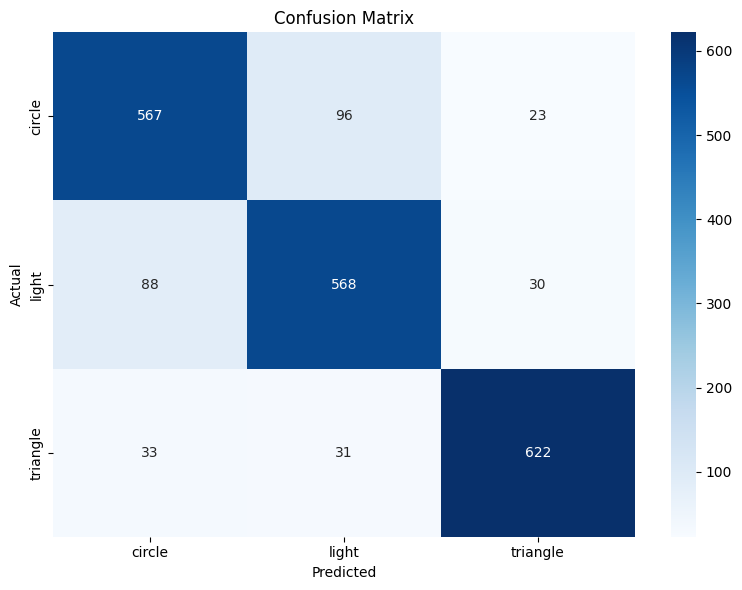

In [273]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=shape_enc.classes_, yticklabels=shape_enc.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [274]:
# Feature Importance
importances = best_model.feature_importances_
indices = importances.argsort()[::-1][:10]
top_features = [features.columns[i] for i in indices]
top_importances = importances[indices]

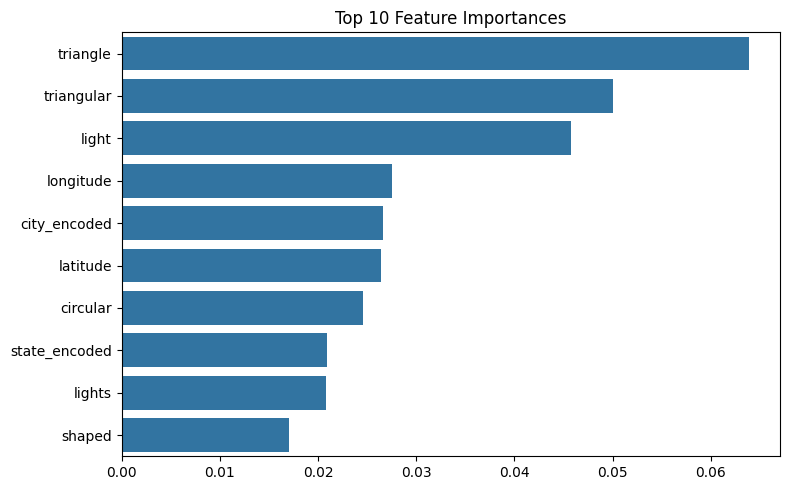

In [275]:
#barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()